In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load the datasets
train_data = pd.read_csv('normall.csv')
test_data = pd.read_csv('anomlaydetection.csv')

# Ensure test data has the same columns as train data
X_test = test_data.drop(columns=['Anomaly'])

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(train_data)
X_test = scaler.transform(X_test)

# Split the training data into training and validation sets
X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=42)

In [19]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Layer
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse
from tensorflow.keras.callbacks import EarlyStopping

# Define the VAE model
input_dim = X_train.shape[1]
latent_dim = 2  # Dimensionality of the latent space

# Encoder
inputs = Input(shape=(input_dim,))
h = Dense(32, activation='relu')(inputs)
h = Dense(16, activation='relu')(h)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Decoder
decoder_h = Dense(16, activation='relu')
decoder_mean = Dense(input_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# VAE model
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, inputs, outputs, z_mean, z_log_var):
        reconstruction_loss = mse(inputs, outputs)
        reconstruction_loss *= input_dim
        kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        return K.mean(reconstruction_loss + kl_loss)

    def call(self, inputs):
        x, x_decoded_mean, z_mean, z_log_var = inputs
        loss = self.vae_loss(x, x_decoded_mean, z_mean, z_log_var)
        self.add_loss(loss)
        return x

# Use functional API to create the custom loss layer
outputs = CustomVariationalLayer()([inputs, x_decoded_mean, z_mean, z_log_var])

# Instantiate and compile the model
vae = Model(inputs, outputs)
vae.compile(optimizer='adam')
vae.summary()

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Train the model
vae.fit(X_train, epochs=100, batch_size=32, validation_data=(X_val, None), callbacks=[early_stopping])

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_48 (Dense)    │ (None, 32)        │        160 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_49 (Dense)    │ (None, 16)        │        528 │ dense_48[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_50 (Dense)    │ (None, 2)         │         34 │ dense_49[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_51 (Dense)    │ (None, 2)         │         34 │ dense_49[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_8 (Lambda)   │ (None, 2)         │          0 │ dense_50[0][0],   │
│                     │                   │            │ dense_51[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_52 (Dense)    │ (None, 16)        │         48 │ lambda_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_53 (Dense)    │ (None, 4)         │         68 │ dense_52[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ custom_variational… │ (None, 4)         │          0 │ input_layer_8[0]… │
│ (CustomVariational… │                   │            │ dense_53[0][0],   │
│                     │                   │            │ dense_50[0][0],   │
│                     │                   │            │ dense_51[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 872 (3.41 KB)

 Trainable params: 872 (3.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 825us/step - loss: 4.9879 - val_loss: 4.4693
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 4.5289 - val_loss: 4.1780
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 4.2075 - val_loss: 3.9826
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 4.1572 - val_loss: 3.9280
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 4.0359 - val_loss: 3.9134
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 3.9722 - val_loss: 3.8997
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 4.0296 - val_loss: 3.8870
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 4.1054 - val_loss: 3.8759
Epoch 9/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 4.0215 - val_loss: 3.8739
Epoch 10/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 4.0941 - val_loss: 3.8765
Epoch 11/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 4.0246 - val_loss: 3.8803
Epoch 12/100
125/12

Train data columns: Index(['bearingA_x', 'bearingA_y', 'bearingB_x', 'bearingB_y'], dtype='object')
Test data columns: Index(['bearingA_x', 'bearingA_y', 'bearingB_x', 'bearingB_y', 'Anomaly'], dtype='object')
Epoch 1/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - loss: 1.2051 - val_loss: 6719175480722849792.0000
Epoch 2/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 1.0307 - val_loss: 108817866752.0000
Epoch 3/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 1.0183 - val_loss: 662738.5625
Epoch 4/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 1.0037 - val_loss: 2264.4512
Epoch 5/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 0.9952 - val_loss: 1796.6681
Epoch 6/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 0.9918 - val_loss: 1736.7845
Epoch 7/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 0.9937 - val_loss: 1730.4873
Epoch 8/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 1.0149 - val_loss: 1728.9430
Epoch 9/100
157/157 ━━━━━━━━━

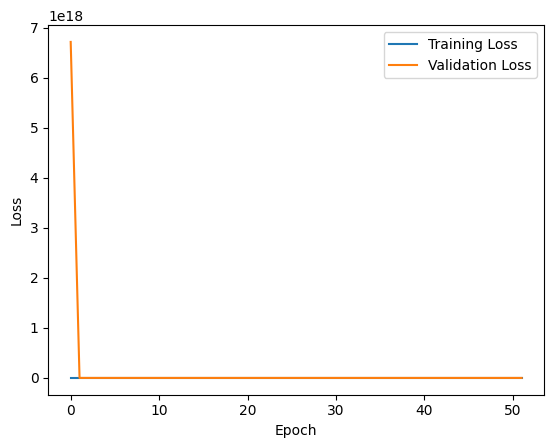

In [32]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow.keras.backend as K

# Load and preprocess data
train_data = pd.read_csv('normall.csv')
test_data = pd.read_csv('anomalydetection.csv')

# Print the column names to verify
print("Train data columns:", train_data.columns)
print("Test data columns:", test_data.columns)

# Use all columns for X_train
X_train = train_data.values

# Drop the 'Anomaly' column from test_data and get X_test
X_test = test_data.drop('Anomaly', axis=1).values

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Parameters
input_dim = X_train.shape[1]
latent_dim = 2
intermediate_dim = 64

# Sampling function for VAE
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Define VAE model
class VAE(Model):
    def __init__(self, input_dim, latent_dim, intermediate_dim, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.intermediate_dim = intermediate_dim
        
        self.encoder = tf.keras.Sequential([
            Input(shape=(input_dim,)),
            Dense(intermediate_dim, activation='relu'),
            Dense(latent_dim + latent_dim)  # z_mean and z_log_var
        ])
        
        self.decoder = tf.keras.Sequential([
            Input(shape=(latent_dim,)),
            Dense(intermediate_dim, activation='relu'),
            Dense(input_dim, activation='sigmoid')
        ])
        
    def call(self, inputs):
        z_mean, z_log_var = tf.split(self.encoder(inputs), num_or_size_splits=2, axis=-1)
        z = sampling([z_mean, z_log_var])
        x_decoded_mean = self.decoder(z)
        kl_loss = -0.5 * K.mean(z_log_var - K.square(z_mean) - K.exp(z_log_var) + 1, axis=-1)
        reconstruction_loss = K.mean(K.square(inputs - x_decoded_mean), axis=-1)
        vae_loss = K.mean(reconstruction_loss + kl_loss)
        self.add_loss(vae_loss)
        return x_decoded_mean

# Instantiate and compile the model
vae = VAE(input_dim=input_dim, latent_dim=latent_dim, intermediate_dim=intermediate_dim)
vae.compile(optimizer=Adam(learning_rate=0.001))

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = vae.fit(X_train, epochs=100, batch_size=32, validation_data=(X_test, None), callbacks=[early_stopping])

# Plot learning curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [33]:
import numpy as np

# Compute reconstruction loss on the test data
def compute_reconstruction_loss(model, X_test):
    X_decoded_mean = model.predict(X_test)
    reconstruction_loss = np.mean(np.square(X_test - X_decoded_mean), axis=-1)
    return reconstruction_loss

# Compute reconstruction loss for the test data
reconstruction_loss = compute_reconstruction_loss(vae, X_test)

# Optional: Set a threshold for anomaly detection
# For example, you could use a percentile-based threshold
threshold = np.percentile(reconstruction_loss, 95)  # Set threshold as 95th percentile

# Identify anomalies based on reconstruction loss
anomalies = reconstruction_loss > threshold

# Print the number of anomalies
print(f"Number of anomalies detected: {np.sum(anomalies)}")
print(f"Total number of test samples: {len(X_test)}")

# If the 'Anomaly' column in test_data has labels, you can compare
if 'Anomaly' in test_data.columns:
    true_anomalies = test_data['Anomaly'].values
    from sklearn.metrics import classification_report
    print(classification_report(true_anomalies, anomalies))

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Number of anomalies detected: 30
Total number of test samples: 595
              precision    recall  f1-score   support

       False       0.24      1.00      0.39       138
        True       1.00      0.07      0.12       457

    accuracy                           0.28       595
   macro avg       0.62      0.53      0.26       595
weighted avg       0.82      0.28      0.19       595



In [53]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import joblib
from tensorflow.keras.layers import Input, Dense, Lambda, Layer
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

# Set random seed
np.random.seed(10)
tf.random.set_seed(10)

# Load data
filename = "normall.csv"
data = pd.read_csv(filename)

# Split data
train = data[0:3000]
test = data[3000:4500]

# Scale data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)

# Define the VAE architecture
input_dim = X_train.shape[1]
latent_dim = 2

# Encoder
inputs = Input(shape=(input_dim,))
h = Dense(64, activation='relu')(inputs)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

# Decoder
latent_inputs = Input(shape=(latent_dim,))
h_decoded = Dense(64, activation='relu')(latent_inputs)
outputs = Dense(input_dim, activation='sigmoid')(h_decoded)

decoder = Model(latent_inputs, outputs, name="decoder")
decoder.summary()

# Define Custom Loss Function
import tensorflow as tf
from tensorflow.keras import backend as K

# Define the VAE loss function
import tensorflow as tf
from tensorflow.keras import backend as K

# Define the VAE loss function
def vae_loss_fn(inputs, x_decoded_mean):
    z_mean, z_log_var = encoder(inputs)[0:2]
    
    # Convert inputs and predictions to the same data type
    inputs = tf.cast(inputs, dtype=tf.float32)
    x_decoded_mean = tf.cast(x_decoded_mean, dtype=tf.float32)
    
    # Compute the binary cross-entropy loss
    xent_loss = input_dim * K.binary_crossentropy(inputs, x_decoded_mean)
    
    # Reduce the xent_loss to shape (batch_size,)
    xent_loss = K.sum(xent_loss, axis=-1)
    
    # Compute the KL divergence loss
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    
    # Combine the losses
    return K.mean(xent_loss + kl_loss)

# Define the custom training step
@tf.function
def train_step(x_batch):
    with tf.GradientTape() as tape:
        # Forward pass
        z_mean, z_log_var, z = encoder(x_batch)
        x_decoded_mean = decoder(z)
        
        # Compute the loss
        loss = vae_loss_fn(x_batch, x_decoded_mean)
        
    # Compute gradients
    grads = tape.gradient(loss, vae.trainable_weights)
    
    # Debug prints
    tf.print("Loss:", loss)
    for i, grad in enumerate(grads):
        tf.print(f"Gradient {i} shape: {grad.shape}")
    
    if None in grads:
        tf.print("Gradients:", grads)
        raise ValueError("One or more gradients are None.")

    # Update weights
    optimizer.apply_gradients(zip(grads, vae.trainable_weights))
    return loss
# Compile the VAE model
optimizer = Adam(learning_rate=0.001)

# Training Loop
epochs = 100
batch_size = 32
history = {'loss': [], 'val_loss': []}

num_batches = X_train.shape[0] // batch_size
for epoch in range(epochs):
    epoch_loss = 0
    for i in range(num_batches):
        batch_x = X_train[i * batch_size:(i + 1) * batch_size]
        loss = train_step(batch_x)
        epoch_loss += loss.numpy()
    
    # Validation loss
    val_loss = np.mean([vae_loss_fn(X_test, vae(X_test)).numpy()])
    
    # Store history
    history['loss'].append(epoch_loss / num_batches)
    history['val_loss'].append(val_loss)
    
    # Print progress
    print(f"Epoch {epoch+1}/{epochs} - Loss: {history['loss'][-1]:.4f} - Val Loss: {history['val_loss'][-1]:.4f}")

# Plot training & validation loss values
plt.figure(figsize=(14, 6))
plt.plot(history['loss'], 'b', label='Train', linewidth=2)
plt.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
plt.title('Model loss', fontsize=16)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Evaluate the model
X_train_pred = vae.predict(X_train)
X_test_pred = vae.predict(X_test)

# Compute loss for training data
train_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)
test_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

# Compute threshold
threshold = np.mean(train_loss) + 3 * np.std(train_loss)

# Determine anomalies
train_anomalies = train_loss > threshold
test_anomalies = test_loss > threshold

# Output results
print("Training Loss Threshold:", threshold)
print("Number of Training Anomalies:", np.sum(train_anomalies))
print("Number of Test Anomalies:", np.sum(test_anomalies))

# Plot loss distribution
plt.figure(figsize=(14, 6))
sns.histplot(train_loss, bins=20, kde=True, color='blue')
plt.title('Training Loss Distribution')
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_47      │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_163 (Dense)   │ (None, 64)        │        320 │ input_layer_47[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_164 (Dense)   │ (None, 2)         │        130 │ dense_163[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_165 (Dense)   │ (None, 2)         │        130 │ dense_163[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_30 (Lambda)  │ (None, 2)         │          0 │ dense_164[0][0],  │
│                     │                   │            │ dense_165[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 580 (2.27 KB)

 Trainable params: 580 (2.27 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_48 (InputLayer)     │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_166 (Dense)               │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_167 (Dense)               │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 452 (1.77 KB)

 Trainable params: 452 (1.77 KB)

 Non-trainable params: 0 (0.00 B)

AttributeError: in user code:

    File "/var/folders/sc/vh_dt4bn43z02nv5hd85s7040000gn/T/ipykernel_6263/4235072280.py", line 107, in train_step  *
        tf.print(f"Gradient {i} shape: {grad.shape}")

    AttributeError: 'NoneType' object has no attribute 'shape'


In [35]:
pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 1.4 MB/s eta 0:00:00a 0:00:01m
Note: you may need to restart the kernel to use updated packages.
